# Transfer learning with TensorFlow part 3: Scaling up 🍔

We've seen the power of transfer learning and fine-tuning with feature extraction, noe it is time to scale up !!!

## Creating helper function

In previous notebook we create series helper function, we import them.

In [1]:
# Importing the helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-02-13 03:12:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   239MB/s    in 6.2s    

2024-02-13 03:12:12 (248 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many image/class are there
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

walk_through_dir(dir_path='101_food_classes_10_percent')

There are 2 directories and 1 images in '101_food_classes_10_percent'.
There are 101 directories and 1 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

## Import the dataset 📈

In [6]:
# Setup data input
import tensorflow as tf

IMG_SIZE=(224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE,
                                                                               shuffle=False) # do not shuffle test data for now

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with Transfer Learning 10% of 101 classes 🍔

In [7]:
# Create a check point callback
checkpoint_path = "101_food_classes_10_percent_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="accuracy",
                                                         save_best_only=True)

In [6]:
# Create a data augmentaion layer to icorporate it right into the model
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    # tf.keras.layers.experimental.preprocessing.Rescaling(1/255.), # We can skip for EfficientNet
], name="Data_Augmentation")

In [7]:
# Set up the mase model and freeze layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_Layers")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global")(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="Output_Layer")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [8]:
# Get a summary of model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Global (GlobalAveragePooli  (None, 1280)              0         
 ng2D)                                                           
                                                                 
 Output_Layer (Dense)        (None, 101)               129381    
                                                             

In [9]:
# Compile a model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

In [10]:
# Fit the model
history_1 = model.fit(train_data_all_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_all_10_percent),
                      validation_data=test_data_all_10_percent,
                      validation_steps=int(0.15*len(test_data_all_10_percent)),
                      callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 159s 627ms/step - loss: 3.3955 - accuracy: 0.2660 - val_loss: 2.4494 - val_accuracy: 0.4600
Epoch 2/5
237/237 [==============================] - 102s 427ms/step - loss: 2.2075 - accuracy: 0.4986 - val_loss: 2.0765 - val_accuracy: 0.4974
Epoch 3/5
237/237 [==============================] - 94s 393ms/step - loss: 1.8187 - accuracy: 0.5706 - val_loss: 1.8784 - val_accuracy: 0.5339
Epoch 4/5
237/237 [==============================] - 82s 346ms/step - loss: 1.6045 - accuracy: 0.6081 - val_loss: 1.8006 - val_accuracy: 0.5463
Epoch 5/5
237/237 [==============================] - 76s 318ms/step - loss: 1.4514 - accuracy: 0.6492 - val_loss: 1.8028 - val_accuracy: 0.5416


In [11]:
# Evaluate the model with whole dataset
model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 53s 67ms/step - loss: 1.5822 - accuracy: 0.5844


[1.582249402999878, 0.5844356417655945]

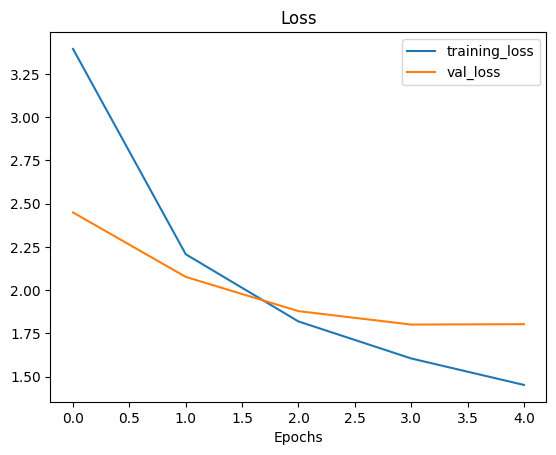

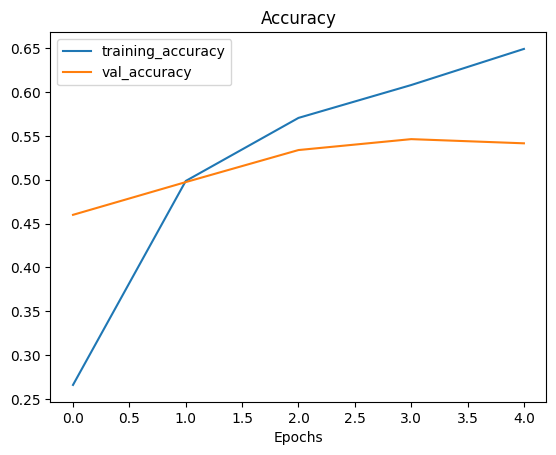

In [12]:
# Plot the loss curves
plot_loss_curves(history=history_1)

> 🤨 **Note:** What do these curves suggest?

> It may suggest our model is over-fitting, performing too well.

> 🤨 **Note:** How cna we solve the over-fitting?

## Fine-tuning the model we have 🤖

In [13]:
# Unfreeze some layers(last 5 layers) in base model
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable=False

In [14]:
# Due to we un-frozen the model we need to re compile it
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), # Fine-tuning the learning rate for 10X
              metrics=["accuracy"])

In [15]:
# Check trainable layer in our model
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_Layers True
Data_Augmentation True
efficientnetb0 True
Global True
Output_Layer True


In [16]:
# Fine-tuning for 5 more epochs
fine_tune_epochs = 10

history_2 = model.fit(train_data_all_10_percent,
                      epochs=fine_tune_epochs,
                      validation_data=test_data_all_10_percent,
                      validation_steps=int(0.15*len(test_data_all_10_percent)),
                      initial_epoch=history_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 77s 297ms/step - loss: 1.2249 - accuracy: 0.6808 - val_loss: 1.7161 - val_accuracy: 0.5561
Epoch 6/10
237/237 [==============================] - 67s 280ms/step - loss: 1.0984 - accuracy: 0.7081 - val_loss: 1.7069 - val_accuracy: 0.5569
Epoch 7/10
237/237 [==============================] - 63s 264ms/step - loss: 1.0077 - accuracy: 0.7284 - val_loss: 1.7191 - val_accuracy: 0.5540
Epoch 8/10
237/237 [==============================] - 53s 223ms/step - loss: 0.9603 - accuracy: 0.7452 - val_loss: 1.6771 - val_accuracy: 0.5617
Epoch 9/10
237/237 [==============================] - 54s 228ms/step - loss: 0.8845 - accuracy: 0.7605 - val_loss: 1.6934 - val_accuracy: 0.5580
Epoch 10/10
237/237 [==============================] - 54s 228ms/step - loss: 0.8434 - accuracy: 0.7712 - val_loss: 1.7048 - val_accuracy: 0.5609


In [17]:
# Evaluate the model with whole data
model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 52s 66ms/step - loss: 1.4966 - accuracy: 0.6038


[1.4965752363204956, 0.6038416028022766]

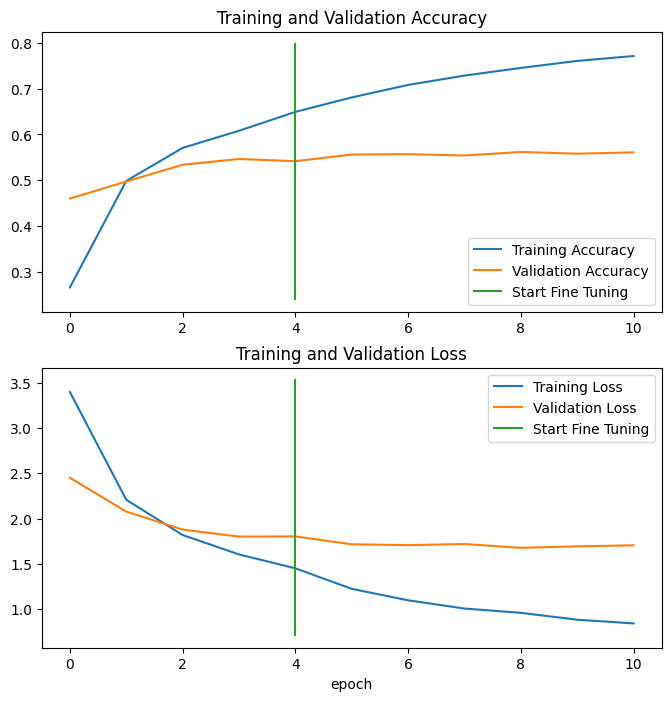

In [18]:
# Compare the histories of feature extraction wih fine-tuning
compare_historys(history_1, history_2)

> 💩 Seems still over-fitting the data still. <br>

## Saving and loadind our model

In [19]:
# Saving and loadind our model
model.save("drive/MyDrive/tensorflow/101_food_classes_10_percent_saved_big_dog_model")

In [20]:
# Load and evaluate our model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow/101_food_classes_10_percent_saved_big_dog_model")

In [21]:
# Evaluate our model
loaded_model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 56s 68ms/step - loss: 1.4966 - accuracy: 0.6038


[1.4965752363204956, 0.6038416028022766]

## Evaluating the performance of the big dog model across all difference classes

Let's make some predictions, visualize them and then later find out which predictions were "most wrong".

In [22]:
# Download pre-trained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-02-13 03:32:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  99.8MB/s    in 0.4s    

2024-02-13 03:32:26 (99.8 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [23]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [4]:
# Load in saved model
loaded_model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [8]:
# Evaluate loaded model the one we just downloaded
result_downloaded_model = loaded_model.evaluate(test_data_all_10_percent)

2024-02-13 07:11:17.549972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25250]
	 [[{{node Placeholder/_4}}]]
2024-02-13 07:11:17.550147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25250]
	 [[{{node Placeholder/_4}}]]
2024-02-13 07:11:17.558555: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


790/790 [==============================] - 218s 275ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with trained model

In [11]:
# Make predictions with model
pred_probs = loaded_model.predict(test_data_all_10_percent, verbose=1)

790/790 [==============================] - 225s 284ms/step


In [12]:
# How many predictions are there
len(pred_probs), pred_probs.shape
pred_classes = pred_probs.argmax(axis=1)


In [13]:
# Let's see what is the first predictions looks like
print(f"What is the highest probability? {100*max(pred_probs[0]):.2f}%")
print(f"What is the class index in this prediction? {pred_probs[0].argmax()}")
print(f"Prediction of the food is:", train_data_all_10_percent.class_names[pred_probs[0].argmax()])

What is the highest probability? 84.74%
What is the class index in this prediction? 52
Prediction of the food is: gyoza


In [14]:
# Unravel test data BatchDataSet
y_label = []

for images, labels in test_data_all_10_percent.unbatch():
  y_label.append(labels.numpy().argmax())

y_label[:10] # Look first ten

2024-02-13 07:19:55.264263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25250]
	 [[{{node Placeholder/_4}}]]
2024-02-13 07:19:55.264462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25250]
	 [[{{node Placeholder/_4}}]]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
# How many y label are there?
len(y_label)

25250

## Evaluating our model's predictions

In [16]:
# Let's try use scikit-learn's accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_label,
                                  pred_classes)

sklearn_accuracy

0.6077623762376237

In [17]:
import numpy as np
from helper_functions import make_confusion_matrix

# Get a list of class name
class_names = test_data_all_10_percent.class_names

# Confusion martrix
make_confusion_matrix(y_label,
                      pred_classes,
                      class_names,
                      figsize=(100, 100),
                      text_size=20)

## Let's keep the evaluation training goining, time for a classification report.

Scikit-learn has a helpful function for acquiring many different classifiaction metrics per class. (e.g. precision recall and F1) called *classification_report*.

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_label,
                            pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

## Create a visualization to have better understanding 👾

In [19]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_label, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [20]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [21]:
# Turn F1 score for dataframe
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)

f1_scores[:10]

class_names  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

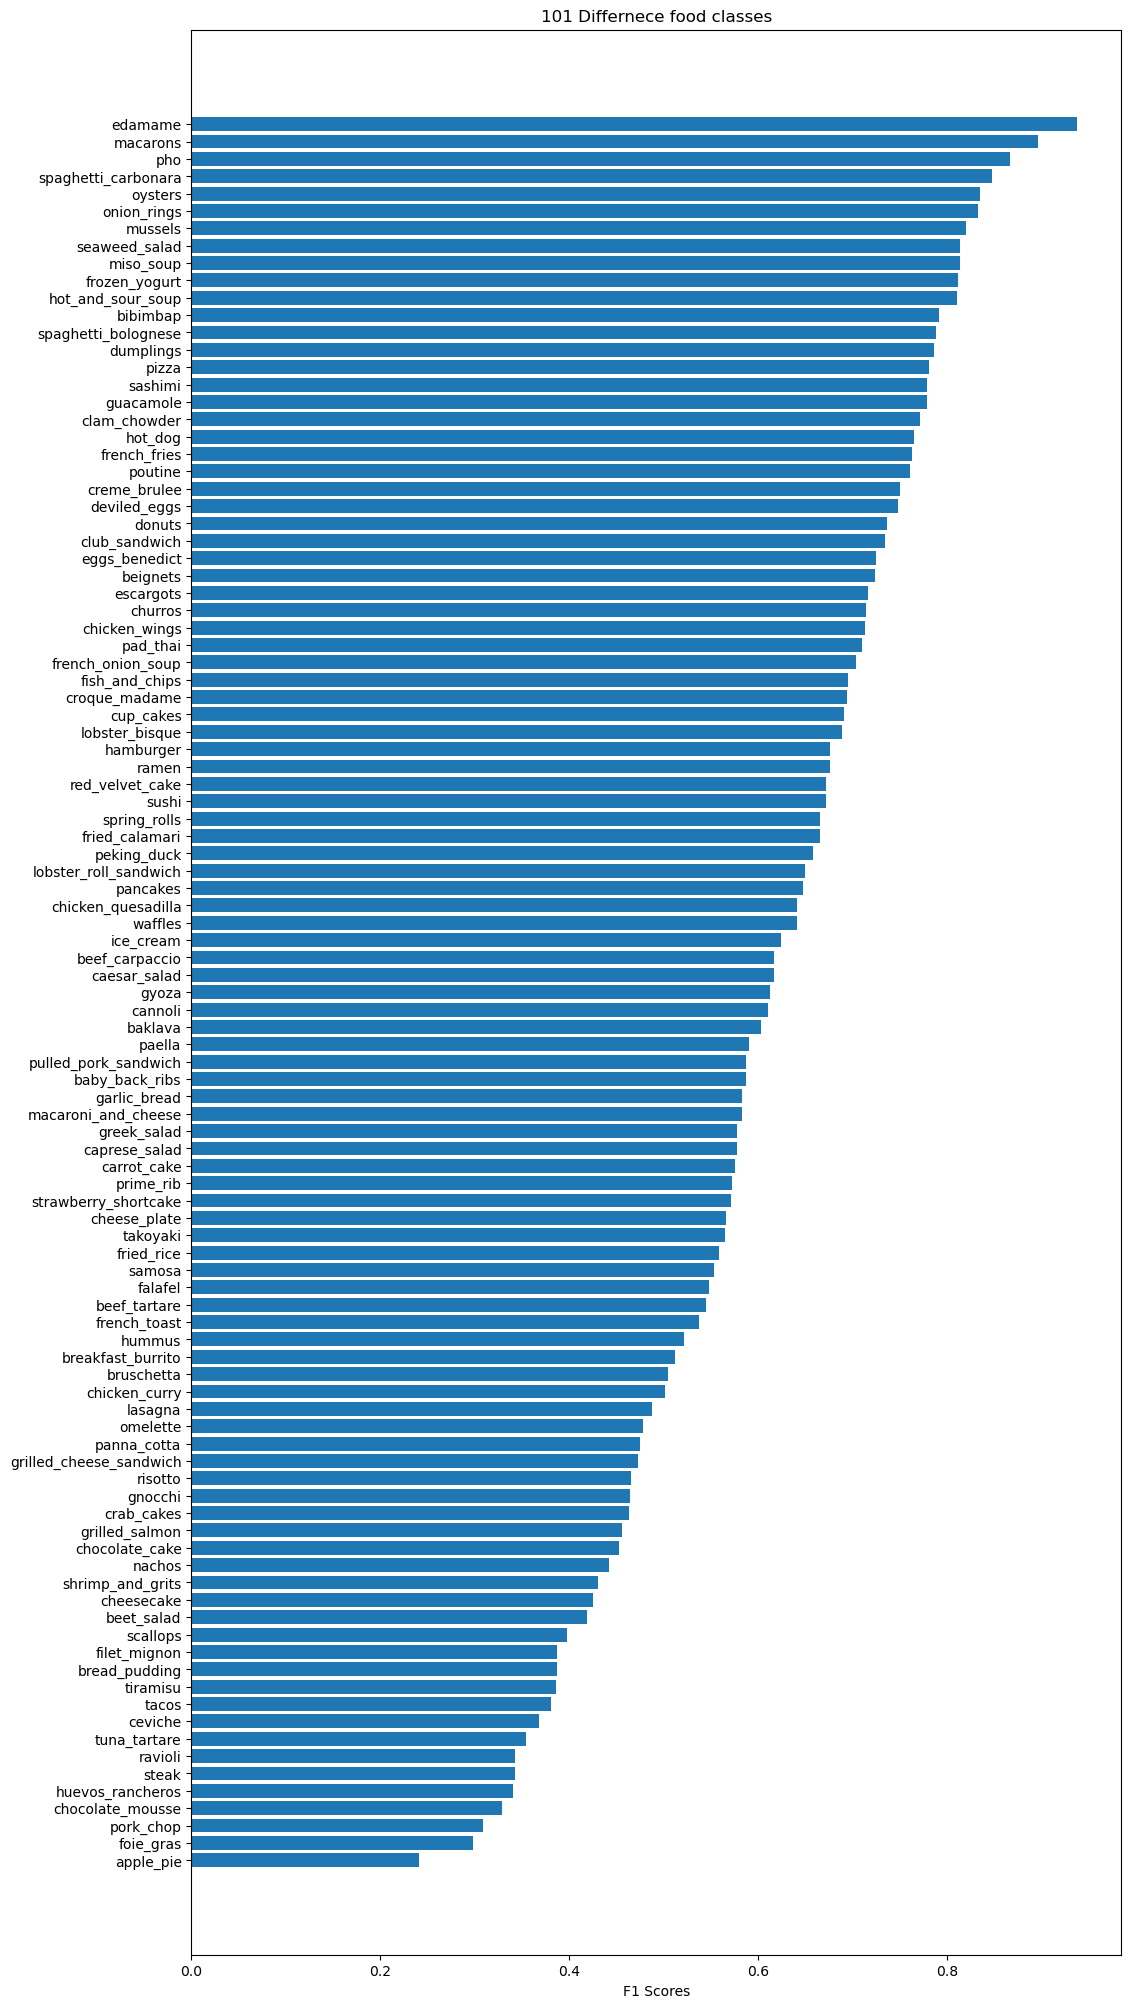

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values) # get f1 scores value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
plt.xlabel("F1 Scores")
ax.set_title("101 Differnece food classes")
ax.invert_yaxis(); # Reverse the order of the plot

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset(images of our own)

To visualize our model's predictions on our own images, we'll need a function to load and pre-process images, specifically it will need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the image into a Tensor using `tf.io.decode_image()`
* Resize the image tensor on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 and 1


In [23]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshape into specific shape.

  Args:
    filename (str): path to target image
    image_shape (int)
    scale (bool)

  Return:
    image
  """

  # Read in target image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images, let's write some code to visualize images, their target label and our model's prediction.

Specifically, we will write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions

1/1 [==============================] - 0s 28ms/step


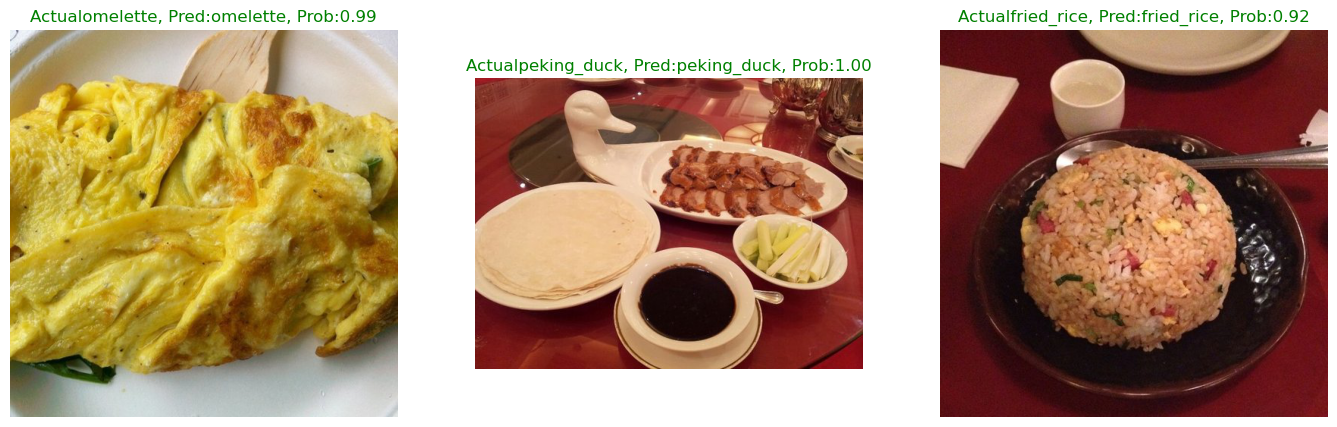

In [33]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))

for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)

  # Choose a random file name
  filename = random.choice(os.listdir(test_dir + "/" + class_name))

  # Create a file path
  file_path = test_dir + "/" + class_name + "/" + filename

  # Load the image and make prediction
  img = load_and_prep_image(file_path, scale=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the images
  plt.subplot(1, 3, i+1)
  
  # Read image using imread
  color_img = plt.imread(file_path)

  # Plot the image using imshow
  plt.imshow(color_img)

  if class_name == pred_class:
    title_color="g"
  else:
    title_color="r"

  plt.title(f"Actual{class_name}, Pred:{pred_class}, Prob:{pred_prob.max():.2f}", c=title_color)
  plt.axis(False);


## Finding the most wrong prediction 🙀

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all the image file paths in the dataset using `list_files()` method
2. Create a pandas `DataFrame` of the image filepaths, ground truth labels,prediction classes (from our model), max prediction probabilities.
3. Use our `DataFrame` to find all the wrong predictions.
4. Sort the `DataFrame` ased on wrong predictions.
5. **Visualize** the images with the highest prediction probabilities but have the wrong prediction.


In [40]:
# 1. Get all of the image file path in the test datdset
filepaths = []
for filepath in test_data_all_10_percent.list_files("101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
    filepaths.append(filepath.numpy())

filepaths[:10]

# 2. Create a pandas DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_label,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1),
                        "y_ture_classname": [class_names[i] for i in y_label],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

pred_df

2024-02-13 08:16:08.624843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25250]
	 [[{{node Placeholder/_0}}]]


img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_ture_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537900          waffles               waffles  
25248   0.501949          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [42]:
#  3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_ture_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [43]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent/test/escargots/1...      35      41   
2663   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
7924   b'101_food_classes_10_percent/test/donuts/3454...      31      29   
18586  b'101_food_classes_10_percent/test/peking_duck...      74      39   
3519   b'101_food_classes_10_percent/test/carrot_cake...      14      21   

       pred_conf       y_ture_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996884            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

In [82]:
len(top_100_wrong)

100

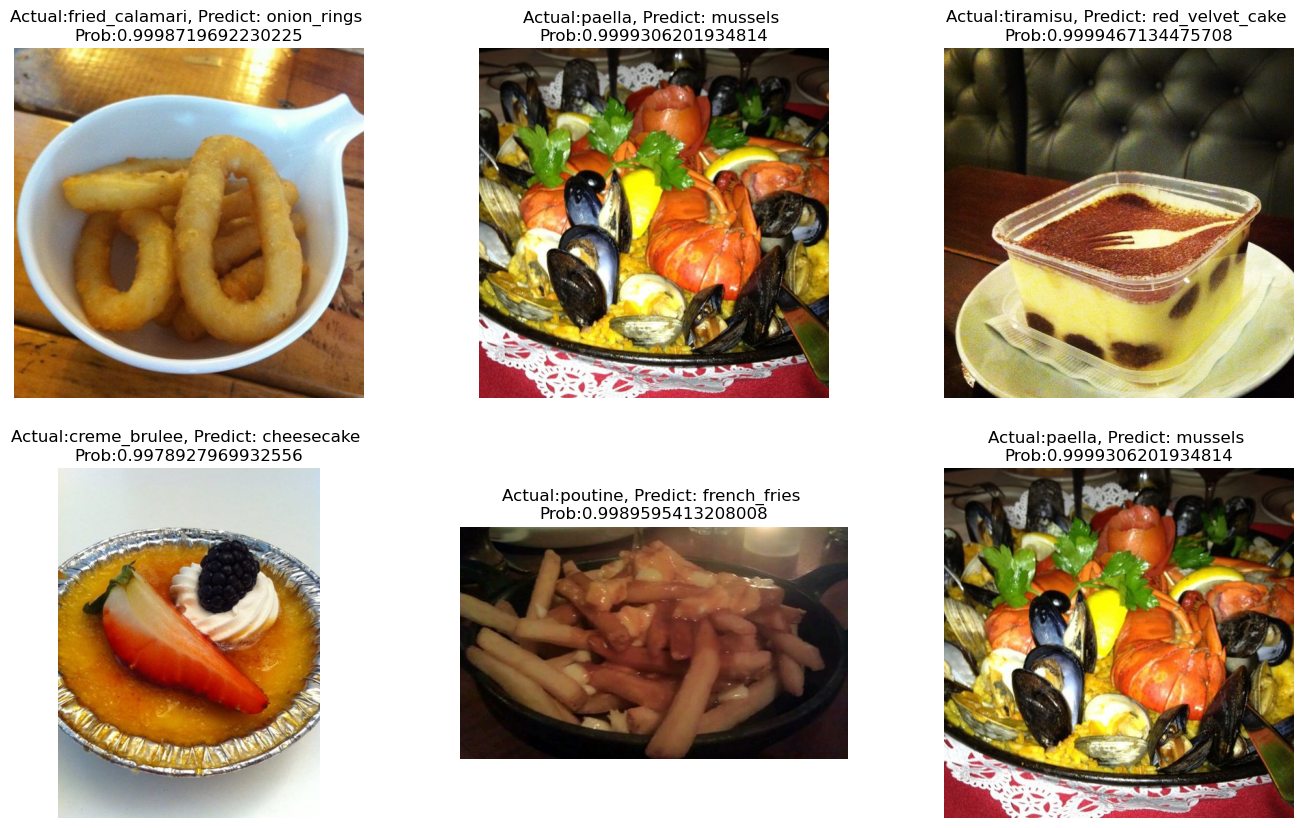

In [110]:
# 5. Visualize the test data samples which have the wrong prediction with high pred_conf

plt.figure(figsize=(17, 10))

for i in range(6):

    j = random.randint(1, len(top_100_wrong))
    # Get the path of it
    img_path = (top_100_wrong.iloc[j-1, 0])

    # Decoding the bytes object to a string
    img_path = img_path.decode('utf-8')

    plt.subplot(2, 3, i+1)

    img_test = plt.imread(img_path)
    plt.imshow(img_test)
    plt.axis(False)

    TrueName = top_100_wrong.iloc[j-1, 4]
    PredictName = top_100_wrong.iloc[j-1, 5]
    PredProb = top_100_wrong.iloc[j-1, 3]
    

    plt.title(f"Actual:{TrueName}, Predict: {PredictName} \nProb:{PredProb}", ) 
